In [ ]:
# ==============================
# 📌 1. Install dependencies
# ==============================
!pip install transformers datasets accelerate evaluate peft matplotlib scikit-learn -q

import torch, time, random, gc
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, get_scheduler
)
from peft import LoraConfig, get_peft_model, PeftModel
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix, classification_report
import evaluate

# Utility: get GPU usage (in MB)
def get_gpu_usage():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**2  # MB
    return 0

# =====================================================
# Prepare Dataset
# =====================================================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

raw = load_dataset("glue", "sst2")
train_full, val = raw["train"], raw["validation"]

# Create balanced train/test splits
train_pos = [i for i, x in enumerate(train_full) if x["label"] == 1]
train_neg = [i for i, x in enumerate(train_full) if x["label"] == 0]
train_idx = random.sample(train_pos, 7500) + random.sample(train_neg, 7500)
remaining = list(set(range(len(train_full))) - set(train_idx))

test_pos = [i for i in remaining if train_full[i]["label"] == 1]
test_neg = [i for i in remaining if train_full[i]["label"] == 0]
test_idx = random.sample(test_pos, 1500) + random.sample(test_neg, 1500)

train_ds = train_full.select(train_idx)
test_ds = train_full.select(test_idx)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

train_tok = train_ds.map(preprocess, batched=True)
test_tok = test_ds.map(preprocess, batched=True)
val_tok = val.map(preprocess, batched=True)

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"]}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [ ]:
# =====================================================
# Train LoRA models
# =====================================================
def train_lora(adapter_name, train_data, val_data, epochs=2):
    base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["query", "value"],
        lora_dropout=0.1,
        bias="none",
        task_type="SEQ_CLS",
    )
    peft_model = get_peft_model(base_model, lora_config)
    args = TrainingArguments(
        output_dir=f"./{adapter_name}_out",
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=epochs,
        learning_rate=2e-5,
        fp16=torch.cuda.is_available(),
        logging_strategy="no",
        eval_strategy="no",    # ✅ replaced 'evaluation_strategy' with 'eval_strategy'
        save_strategy="no"

    )

    trainer = Trainer(
        model=peft_model,
        args=args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    print(f"Training {adapter_name}...")
    trainer.train()
    peft_model.save_pretrained(adapter_name)
    print(f"{adapter_name} saved ✅")

    # Free memory
    del base_model, peft_model, trainer
    gc.collect()
    torch.cuda.empty_cache()

# 🧠 Train two adapters
train_lora("lora_a", train_tok, val_tok, epochs=15)
train_lora("lora_b", train_tok, val_tok, epochs=15)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2917473319.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training lora_a...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: deepmakadiya2004 (deepmakadiya2004-l-d-college-of-engineering) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


Step,Training Loss


lora_a saved ✅


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2917473319.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training lora_b...


Step,Training Loss


lora_b saved ✅


In [ ]:
# =====================================================
# Fusion Model
# =====================================================
base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

adapter_a = PeftModel.from_pretrained(
    AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2),
    "lora_a"
)
adapter_b = PeftModel.from_pretrained(
    AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2),
    "lora_b"
)

# Freeze all non-LoRA parameters
for model in [adapter_a, adapter_b]:
    for name, param in model.named_parameters():
        if "lora_" not in name:
            param.requires_grad = False
for param in base_model.parameters():
    param.requires_grad = False

# ✅ Fixed FusionModel
class FusionModel(torch.nn.Module):
    def __init__(self, base_model, adapters):
        super().__init__()
        self.models = torch.nn.ModuleList(adapters)
        self.fusion_weights = torch.nn.Parameter(torch.ones(len(adapters)))
        self.base_classifier = base_model.classifier  # optional

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        logits_list = []
        for model in self.models:
            out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits_list.append(out.logits.unsqueeze(0))
        logits_stack = torch.cat(logits_list, dim=0)
        weights = torch.nn.functional.softmax(self.fusion_weights, dim=0)
        fused_logits = torch.einsum("a,abn->bn", weights, logits_stack)
        loss = None
        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(fused_logits, labels)
        return {"loss": loss, "logits": fused_logits}

device = "cuda" if torch.cuda.is_available() else "cpu"
fusion_model = FusionModel(base_model, [adapter_a, adapter_b]).to(device)

# =====================================================
# ✅ Print number of parameters
# =====================================================
total_params = sum(p.numel() for p in fusion_model.parameters())
trainable_params = sum(p.numel() for p in fusion_model.parameters() if p.requires_grad)
percent = 100 * trainable_params / total_params

print(f"\n🔢 Model Parameter Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({percent:.4f}% of total)\n")

# =====================================================
# DataLoader + Collate
# =====================================================
def collate_fn(batch):
    max_len = max(len(x["input_ids"]) for x in batch)
    input_ids = torch.tensor([x["input_ids"] + [0]*(max_len - len(x["input_ids"])) for x in batch])
    attention_mask = torch.tensor([x["attention_mask"] + [0]*(max_len - len(x["attention_mask"])) for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_loader = DataLoader(train_tok, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_tok, batch_size=32, shuffle=False, collate_fn=collate_fn)

# =====================================================
# Fusion Training
# =====================================================
optimizer = AdamW(filter(lambda p: p.requires_grad, fusion_model.parameters()), lr=1e-4)
num_training_steps = len(train_loader) * 5
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

scaler = GradScaler()
train_losses, val_losses, gpu_usages = [], [], []

print("Starting Fusion Training...")
start_time = time.time()

for epoch in range(15):
    fusion_model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with autocast(enabled=True):
            outputs = fusion_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    gpu_usages.append(get_gpu_usage())

    # 🔍 Validation
    fusion_model.eval()
    val_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            with autocast(enabled=True):
                outputs = fusion_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs["loss"]
            val_loss += loss.item()
            preds = torch.argmax(outputs["logits"], dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/15| Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | GPU: {gpu_usages[-1]:.2f} MB")

print("Fusion training completed in:", time.time() - start_time, "seconds")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔢 Model Parameter Summary:
Total parameters: 219,561,996
Trainable parameters: 2 (0.0000% of total)

Starting Fusion Training...


/tmp/ipython-input-2133463690.py:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2133463690.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/tmp/ipython-input-2133463690.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 1/15| Train Loss: 0.2417 | Val Loss: 0.2562 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 2/15| Train Loss: 0.2416 | Val Loss: 0.2561 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 3/15| Train Loss: 0.2403 | Val Loss: 0.2562 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 4/15| Train Loss: 0.2409 | Val Loss: 0.2561 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 5/15| Train Loss: 0.2400 | Val Loss: 0.2561 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 6/15| Train Loss: 0.2406 | Val Loss: 0.2561 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 7/15| Train Loss: 0.2403 | Val Loss: 0.2561 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 8/15| Train Loss: 0.2402 | Val Loss: 0.2561 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 9/15| Train Loss: 0.2400 | Val Loss: 0.2561 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 10/15| Train Loss: 0.2370 | Val Loss: 0.2561 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 11/15| Train Loss: 0.2410 | Val Loss: 0.2561 | Val Acc: 0.9014 | GPU: 859.29 MB
Epoch 12/15| Train Loss: 0.2420 | Val Loss: 0.2561 | Val Acc: 0


Final Validation Confusion Matrix:
[[383  45]
 [ 41 403]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9033    0.8949    0.8991       428
           1     0.8996    0.9077    0.9036       444

    accuracy                         0.9014       872
   macro avg     0.9014    0.9013    0.9013       872
weighted avg     0.9014    0.9014    0.9014       872



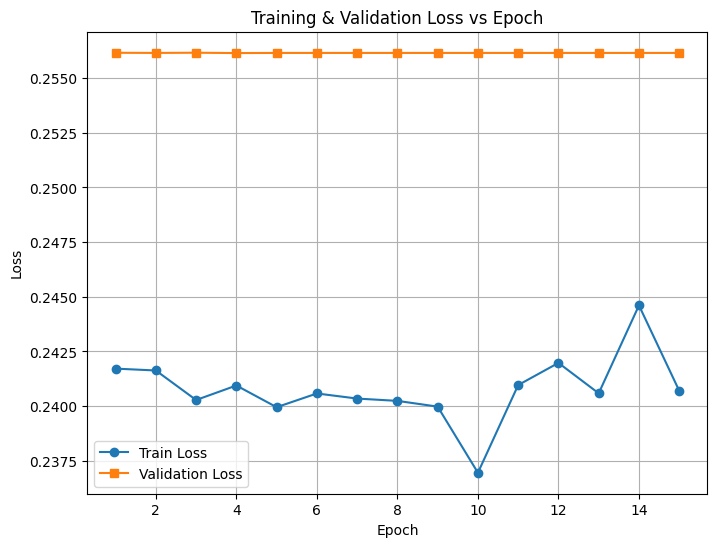

In [ ]:
# ========================================
# ✅ Confusion Matrix & Classification Report
# ========================================
print("\nFinal Validation Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# ========================================
# 📊 Plot Results
# ========================================
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker="o", label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, marker="s", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs Epoch")
plt.legend()
plt.grid()
plt.show()